In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

#import pydicom
#!pip install -qU python-gdcm pydicom pylibjpeg

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [17]:
df['filepath'] = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/' + df['patient_id'].astype(str) + '/' + df['image_id'].astype(str) + '.png'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10011/220375232.png


In [18]:
df.iloc[0,-1]

'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10006/462822612.png'

In [19]:
df = df[['filepath', 'cancer']]
df.head()

,filepath,cancer
0,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10006/462822612.png,0
1,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10006/1459541791.png,0
2,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10006/1864590858.png,0
3,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10006/1874946579.png,0
4,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/10011/220375232.png,0


In [20]:
df.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

# Train Test Split

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets, stratified by the "target" column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cancer'])
print('shape of train_df', train_df.shape)
print('shape of test_df', test_df.shape)

shape of train_df (43764, 2)
shape of test_df (10942, 2)


# Sampling

In [22]:
# Class count
count_class_0, count_class_1 = df.cancer.value_counts()

# Divide by class
df_class_0 = train_df[train_df['cancer'] == 0]
df_class_1 = train_df[train_df['cancer'] == 1]

In [23]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1*5, random_state=1)
df_class_1_over = df_class_1.sample(count_class_1*5, replace=True)
df_test_over_under = pd.concat([df_class_0_under, df_class_1_over], axis=0)

print('Random under-sampling:')
print(df_test_over_under.cancer.value_counts())

Random under-sampling:
0    5790
1    5790
Name: cancer, dtype: int64


In [24]:
df_test_over_under.head()

,filepath,cancer
54496,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/9718/73690385.png,0
23232,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/34779/1647524429.png,0
20678,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/31931/44562264.png,0
7197,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/17682/1188922527.png,0
31077,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_768/train_images_processed_768/43317/1232413482.png,0


In [25]:
df_test_over_under.shape

(11580, 2)

# Training

In [26]:
db = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                   get_x=lambda x:x[0],
                   get_y=lambda x:x[1],
                   splitter  = RandomSplitter())

dls = db.dataloaders(df_test_over_under.values, num_workers=0, bs=16)

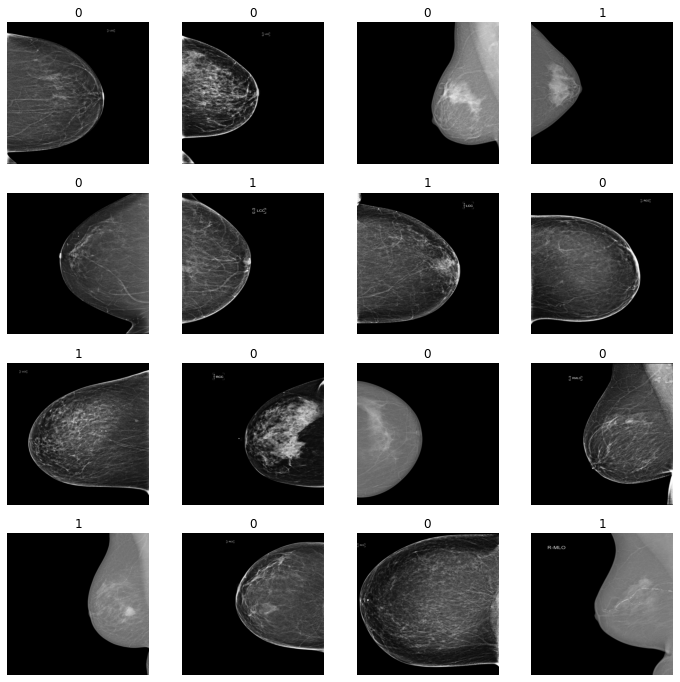

In [27]:
#dls = db.dataloaders(df.values)
dls.show_batch(max_n=16)

In [28]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [29]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.747547,0.651684,0.367444,08:11


epoch,train_loss,valid_loss,error_rate,time
0,0.553615,0.599158,0.293178,08:17
1,0.396148,0.314079,0.124352,08:15
2,0.107185,0.161343,0.056563,08:15
3,0.041622,0.085912,0.023748,07:40


In [33]:
learn.save('ous_768_resnet_ft', with_opt=False)

Path('models/ous_768_resnet_ft.pth')

# Validation Data Metric

In [41]:
# interp = ClassificationInterpretation.from_learner(learn)
# losses,idxs = interp.top_losses()
# len(dls.valid_ds)==len(losses)==len(idxs)
# interp.plot_confusion_matrix(figsize=(7,7))

# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

In [42]:
# interp.plot_top_losses(5, nrows=1)

# Test Data Metric

In [3]:
temp = learn.predict('/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_dicomsdl_256/train_images_processed_cv2_dicomsdl_256/10006/1459541791.png')
temp[0]

In [44]:
def pfbeta_torch(labels, preds, beta=1):
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0.0

In [52]:
test_df.shape

(10942, 2)

In [ ]:
# from tqdm import tqdm

# labels = []
# preds = []

# #preds = learn.predict(test_df['filepath'])
# #labels = test_df['cancer']

# # for _, row in tqdm(test_df.iterrows()):
# #     #pred = learn.predict(row.filepath)[0]
# #     #preds.append(learn.predict(row.filepath)[0])#pred)
# #     label = row.cancer
# #     labels.append(label)

# score = pfbeta_torch(labels, preds, beta=1)
# print(score)

In [59]:
# score = pfbeta_torch(labels, preds, beta=1)
# print(score)

In [63]:
#np.save('/kaggle/working/', preds)

In [64]:
#np.save('/kaggle/working/', labels)